# "Quadrant" predictions for 3-bin trends

- Working with the 3-bin data. Eg, say "a" appears `(100, 90, 70)` times in the three bins.
- Represent that as a 2d vector, where the first dimension is the difference in frequency between bins 1 and 2, the second dimension is the difference between bins 2 and 3. So, here - `(-10, -20)`.
- Relativize the values by the total frequency of the word across all 3 bins.
- Do this for all texts, plot on a 2d plane, where the X-axis is the signed difference between bins 1->2, Y-axis is difference between bins 2->3.
- Label each text with its quadrant location, and see if those labels can be reproduced by a supervised machine learning algorithm.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
import bz2
import os
import ujson
import attr
import math
import random

import pandas as pd
import numpy as np

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from collections import OrderedDict, defaultdict
#from pyemd import emd

from sklearn.cluster import AgglomerativeClustering
from scipy import stats

In [4]:
@attr.s
class Dataset:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
    
    def novels(self):
        for path in tqdm_notebook(self.paths()):
            with bz2.open(path) as fh:
                for line in fh:
                    yield ujson.loads(line)

In [5]:
ds = Dataset('../data/top200-4bins.json/')

In [6]:
novels = list(ds.novels())

In [164]:
def quad_chart(quads, points, null=False, 
               w=5, h=5, xlim=(-0.2,0.2), ylim=(-0.2,0.2)):
    q1, q2, q3, q4 = quads
    x, y = points
    
    plt.figure(figsize=(w,h))
    plt.axhline(0, c='black', linewidth=1)
    plt.axvline(0, c='black', linewidth=1)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    # The empirical data:
    plt.scatter(x, y, s=1, alpha=0.4, color='darkblue')
    
    # The mean of the empirical data:
    plt.plot([np.mean(x)], [np.mean(y)], color='black', markersize=7, marker='o')
    
    plt.xlabel('← Falls in first half     Rises in first half →', fontsize=18)
    plt.ylabel('← Falls in second half     Rises in second half →', fontsize=18)
    
    # The STD ellipses:
    plt.gca().add_artist(std_ellipse(x, y, n_std=1, alpha=0.15, color='indigo'))
    plt.gca().add_artist(std_ellipse(x, y, n_std=2, alpha=0.1, color='indigo'))
    plt.gca().add_artist(std_ellipse(x, y, n_std=3, alpha=0.05, color='indigo'))

    # The null hypothesis ellipses:
    if null == True:
        plt.gca().add_artist(std_ellipse(x, y, n_std=1, null=True, alpha=0.4, 
                                         fill=False, color='darkgreen', linewidth=2))
        plt.gca().add_artist(std_ellipse(x, y, n_std=2, null=True, alpha=0.4, 
                                         fill=False, color='darkgreen', linewidth=2))
        plt.gca().add_artist(std_ellipse(x, y, n_std=3, null=True, alpha=0.4, 
                                         fill=False, color='darkgreen', linewidth=2))
    elif null:
        x_null, y_null = null
        plt.gca().add_artist(std_ellipse(x_null, y_null, n_std=1, null=False, alpha=0.4, 
                                         fill=False, color='darkgreen', linewidth=2))
        plt.gca().add_artist(std_ellipse(x_null, y_null, n_std=2, null=False, alpha=0.4, 
                                         fill=False, color='darkgreen', linewidth=2))
        plt.gca().add_artist(std_ellipse(x_null, y_null, n_std=3, null=False, alpha=0.4, 
                                         fill=False, color='darkgreen', linewidth=2))
    
    # The corner plots:
    ax = plt.axes([0.15, 0.8, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q1.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q1)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.82, 0.8, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q2.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q2)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.15, 0.14, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q3.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q3)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.axes([0.82, 0.14, 0.05, 0.05])
    ax.margins(0.2, 0.2)
    plt.plot(q4.sum(0), marker='o')
    plt.title('{:.2%}'.format(len(q4)/len(x)), fontsize=18)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

def quad_to_conditional_rise(quartiles):
    a, b, c, d = quartiles
    return b / (a + b) - 0.5, d / (c + d) - 0.5

def plot_quarter_quad(token, null=None, **kwargs):
    counts = [np.array(novel['counts'][token]) for novel in novels]
    counts = np.stack([s for s in counts if s.sum() > 100])
    
    q1 = np.stack([s for s in counts if s[1]-s[0] <  0 and s[3]-s[2] >= 0])
    q2 = np.stack([s for s in counts if s[1]-s[0] >= 0 and s[3]-s[2] >= 0])
    q3 = np.stack([s for s in counts if s[1]-s[0] <  0 and s[3]-s[2] <  0])
    q4 = np.stack([s for s in counts if s[1]-s[0] >= 0 and s[3]-s[2] <  0])

    x, y = [], []
    for s in counts:
        sx, sy = quad_to_conditional_rise(s)
        x.append(sx)
        y.append(sy)
    
    if null == 'multinomial':
        x_null, y_null = [], []
        for s in counts:
            s = np.random.multinomial(s.sum(), [1/4, 1/4, 1/4, 1/4])
            sx, sy = quad_to_conditional_rise(s)
            x_null.append(sx)
            y_null.append(sy)

        quad_chart([q1, q2, q3, q4], 
                   [x, y],
                   [x_null, y_null],
                   **kwargs)
    elif null == 'equal_variance':
        quad_chart([q1, q2, q3, q4], 
                   [x, y],
                   True,
                   **kwargs)
    else:
        quad_chart([q1, q2, q3, q4],
                   [x, y],
                   **kwargs)

def plot_quarter_quad_pair(token1, token2, combine=np.add, **kwargs):
    counts1 = [np.array(novel['counts'][token1]) for novel in novels]
    counts2 = [np.array(novel['counts'][token2]) for novel in novels]
    
    include = [c1.sum() > 100 and c2.sum() > 100 
               for c1, c2 in zip(counts1, counts2)]
    
    counts1 = np.stack([c for c, i in zip(counts1, include) if i])   
    counts2 = np.stack([c for c, i in zip(counts2, include) if i])
    
    x1, y1, x2, y2, x, y = [], [], [], [], [], []
    for c1, c2 in zip(counts1, counts2):
        x1.append(c1[1] / (c1[0] + c1[1]) - 0.5)
        x2.append(c2[1] / (c2[0] + c2[1]) - 0.5)
        y1.append(c1[3] / (c1[2] + c1[3]) - 0.5)
        y2.append(c2[3] / (c2[2] + c2[3]) - 0.5)
        x.append(combine(x2[-1], x1[-1]))
        y.append(combine(y2[-1], y1[-1]))
    
    counts = combine(counts2, counts1)
    
    q1 = np.stack([s for s in counts if s[1]-s[0] <  0 and s[3]-s[2] >= 0])
    q2 = np.stack([s for s in counts if s[1]-s[0] >= 0 and s[3]-s[2] >= 0])
    q3 = np.stack([s for s in counts if s[1]-s[0] <  0 and s[3]-s[2] <  0])
    q4 = np.stack([s for s in counts if s[1]-s[0] >= 0 and s[3]-s[2] <  0])
    
    quad_chart([q1, q2, q3, q4], 
               [x, y],
               **kwargs)

def cols_to_data_mat(*dims):
    return np.array(list(zip(*dims)))

def sample_covariance_matrix(data_mat):
    """This exists *only* to document how `cov` works in this case."""
    data_mean = data_mat.mean(axis=0)
    data_mat -= data_mean
    cov = (data_mat.T @ data_mat) / (len(data_mat) - 1)
    assert np.isclose(cov, np.cov(data_mat.T)).all()
    return cov

def sample_std_ellipse_params(data_mat, n_std, null=None):
    # Columns of U are the eigenvectors of the covariance matrix.
    data_cov = np.cov(data_mat.T)
    u, s, v = np.linalg.svd(data_cov)
    first_eigv = u[:,0]
    fe_x, fe_y = first_eigv
    
    angle = np.degrees(np.arctan2(fe_y, fe_x))
    
    width, height = 2 * n_std * np.sqrt(s)
    if null == 'mean_centered':
        mean_len = 2 * n_std * (np.sum(s) / 2) ** 0.5
        return (data_mat.mean(axis=0), mean_len, mean_len, 0)
    elif null:
        mean_len = 2 * n_std * (np.sum(s) / 2) ** 0.5
        return ([0, 0], mean_len, mean_len, 0)
    else:
        return (data_mat.mean(axis=0), width, height, angle)


def std_ellipse(x, y, n_std, null=False, **kwargs):
    params = sample_std_ellipse_params(cols_to_data_mat(x, y), n_std, null=null)
    pos, width, height, angle = params
    return mpl.patches.Ellipse(xy=pos, 
                               width=width, 
                               height=height, 
                               angle=angle, 
                               **kwargs)

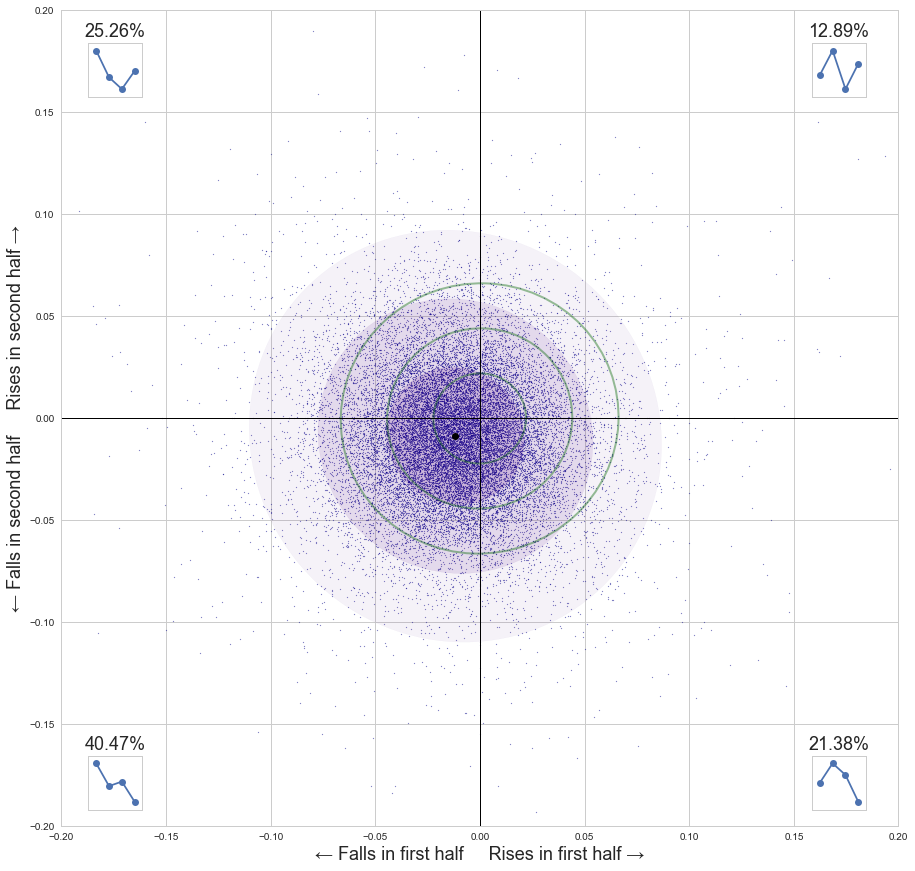

In [168]:
plot_quarter_quad('a', null='multinomial', w=15, h=15)

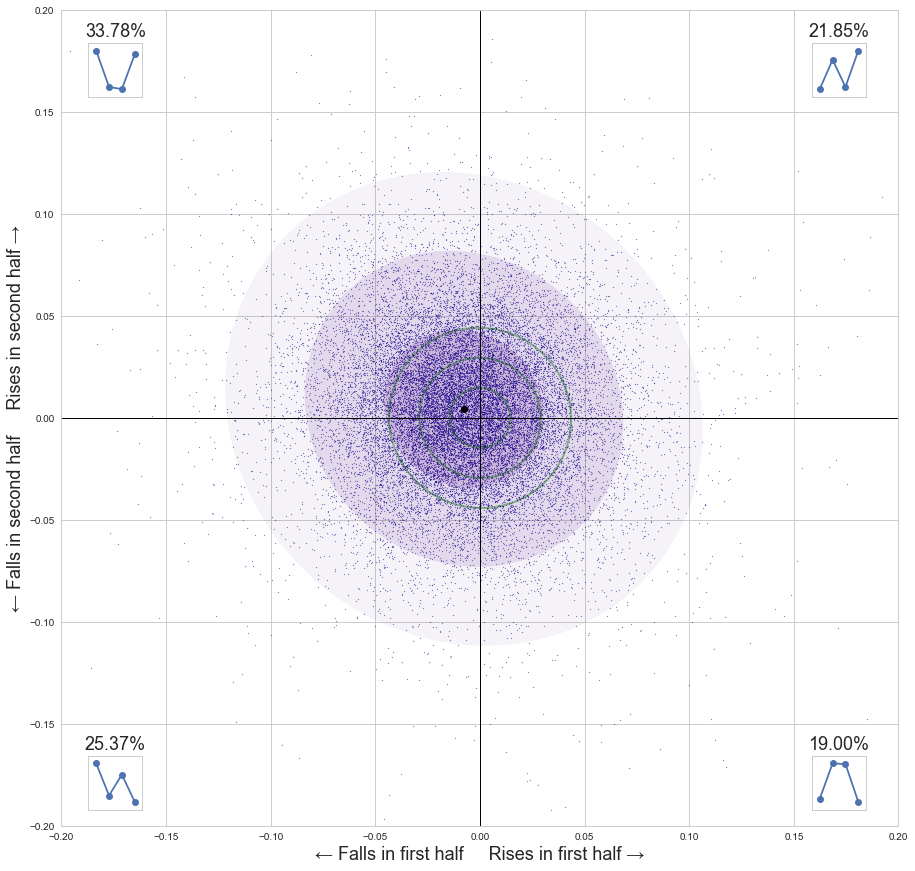

In [170]:
plot_quarter_quad('the', null='multinomial', w=15, h=15)

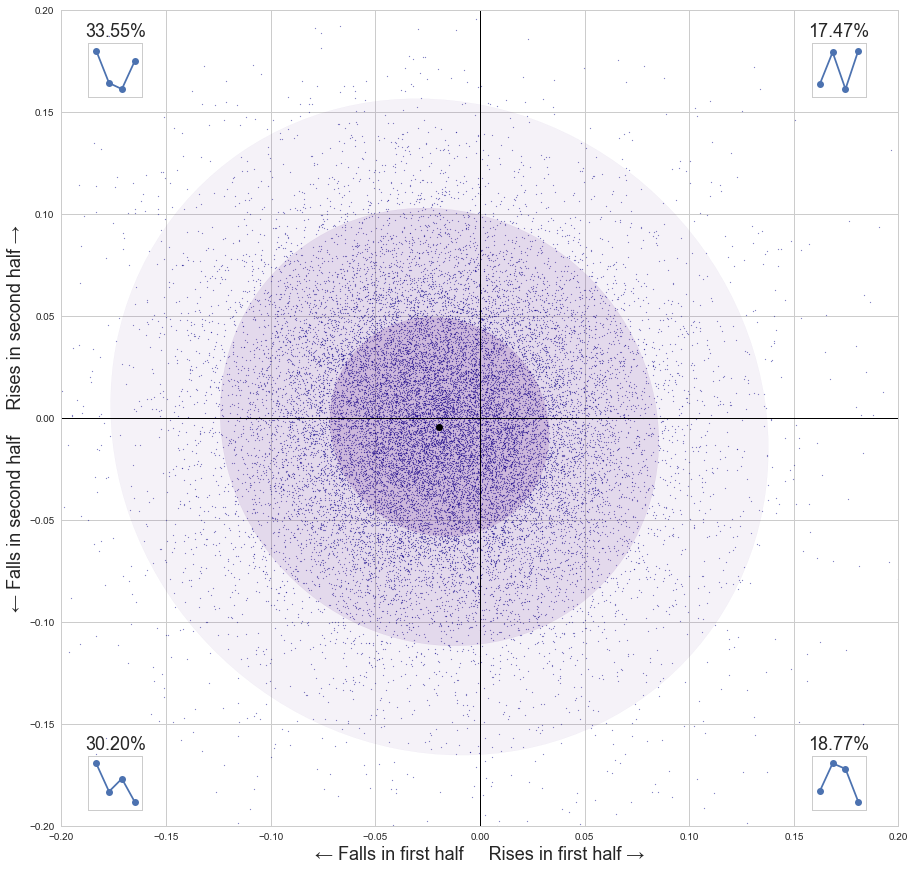

In [167]:
plot_quarter_quad_pair('a', 'the', combine=np.add, w=15, h=15)